**Stores sale - Time Series Forecasting**  
Kaggle competition  
<https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rc('figure', figsize=(20, 10))
from sklearn.preprocessing import LabelEncoder
from scipy.stats.stats import pearsonr

from datetime import datetime

In [85]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score

1. Load datasets

In [3]:
files = os.listdir('data')

In [4]:
file_names = ['holidays','oil_prices','sample', 'stores','df_test','df_train','transactions']

In [5]:
# let read all files, although we won't use sample and df_test dataset
for i in range(len(files)):
    vars()[str(file_names[i])] = pd.read_csv('data/' + files[i])
    
    

**2. Preliminary data analysis**

- df_train


In [6]:
df = df_train
df
# The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
# store_nbr identifies the store at which the products are sold.
# family identifies the type of product sold.
# sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
# onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


We would like focus on total sale, so let aggregate date and drop useless columns

In [7]:
df['date']= pd.to_datetime(df['date'])
df = df.groupby(['date'])['sales'].sum().to_frame()
df = df.asfreq('d').fillna(0)
df

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


In our date set we have sales beetween 2013-01-01 to 2017-08-15

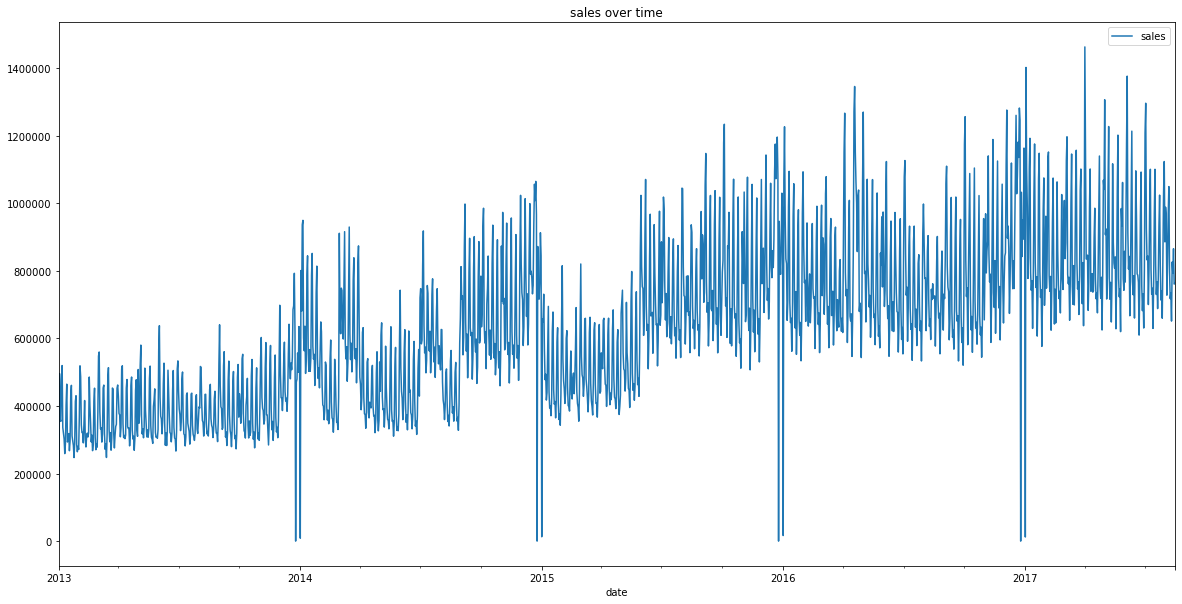

In [8]:
df.plot()
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.show()

How we can see in sales we have clear trend over those years, and seasional trend near the end of the year

- stores

In [9]:
# we have list of stores, which sale we will predict.
stores.sample(10)

,store_nbr,city,state,type,cluster
51,52,Manta,Manabi,A,11
36,37,Cuenca,Azuay,D,2
13,14,Riobamba,Chimborazo,C,7
22,23,Ambato,Tungurahua,D,9
30,31,Babahoyo,Los Rios,B,10
32,33,Quevedo,Los Rios,C,3
48,49,Quito,Pichincha,A,11
35,36,Libertad,Guayas,E,10
1,2,Quito,Pichincha,D,13
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6


In [10]:
# we have 54 different stores
print('number of stores =', stores['store_nbr'].unique().size)

number of stores = 54


In [11]:
# stores are clustered on 17 clusters
print('clusters_number = ', stores['cluster'].value_counts().size)

clusters_number =  17


In [12]:
# stores are distinguished by 5 types
print('types_number = ', stores['type'].value_counts().size)

types_number =  5


- oil prices

In [13]:
# Ecuador market is oil prices dependent so we should take them into consideration
oil_prices.sample(10)

,date,dcoilwtico
380,2014-06-17,106.95
587,2015-04-02,49.13
761,2015-12-02,39.93
741,2015-11-04,46.32
660,2015-07-14,53.05
184,2013-09-16,106.54
268,2014-01-10,92.39
386,2014-06-25,107.04
368,2014-05-30,103.40
949,2016-08-22,46.80


In [14]:
# let set date as index and fill NaN for empty dates
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
oil_prices = oil_prices.set_index('date').asfreq('d')
oil_prices.fillna(method = 'bfill', inplace = True)
oil_prices.rename(columns = {'dcoilwtico': 'oil_price'}, inplace= True)
oil_prices

,oil_price
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.20
...,...
2017-08-27,46.40
2017-08-28,46.40
2017-08-29,46.46


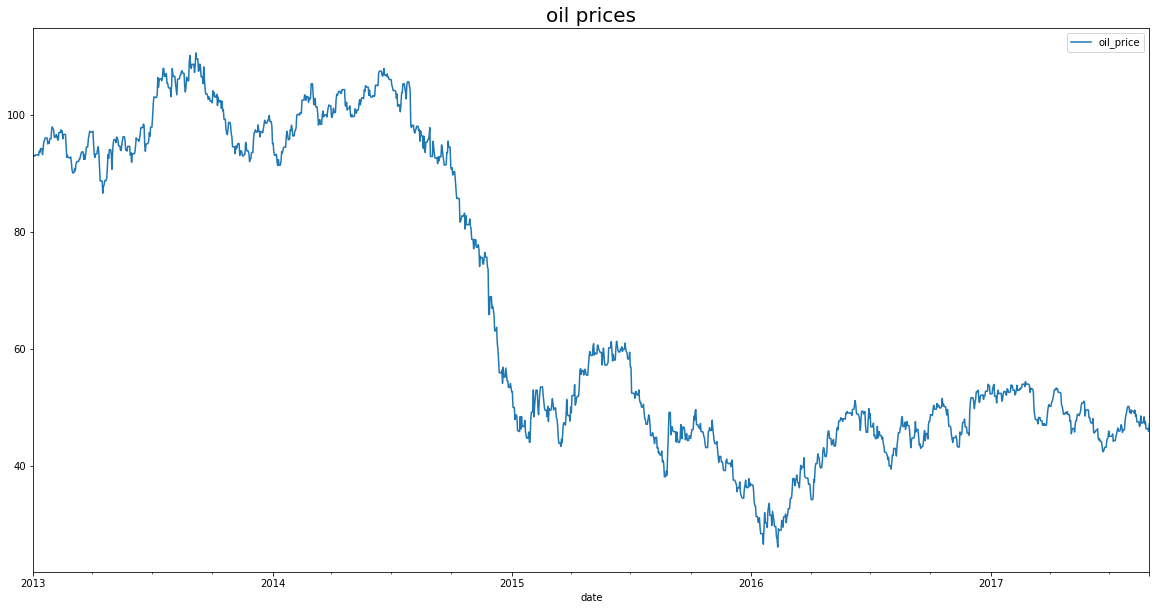

In [15]:
# oil prices over time
oil_prices.plot(figsize = (20,10))
plt.title ('oil prices', size = 20)
plt.show()

<AxesSubplot:xlabel='date'>

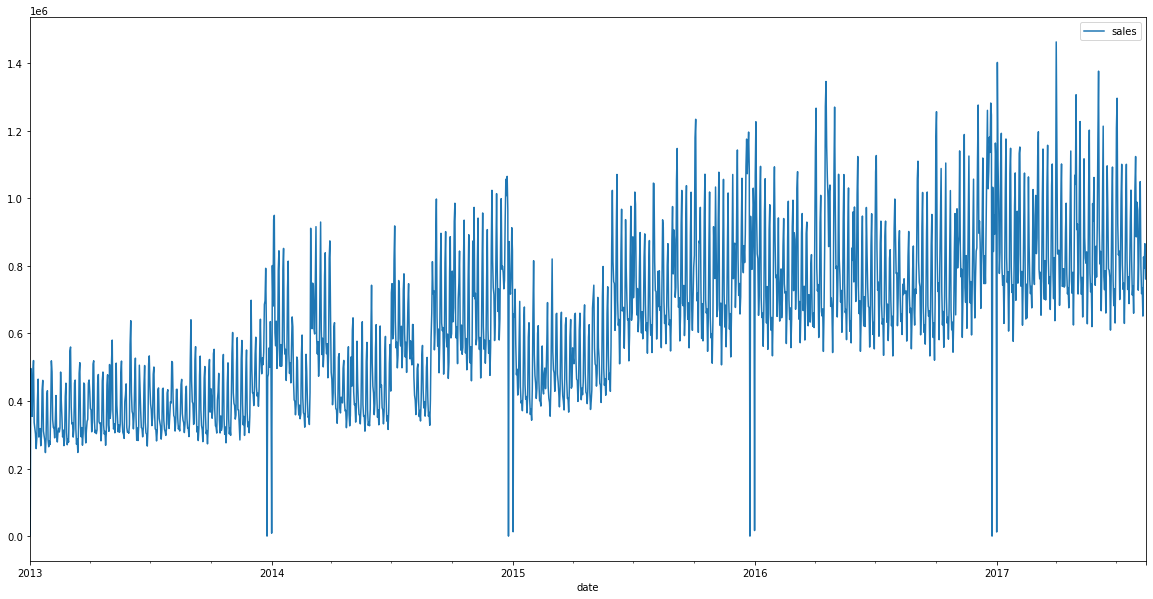

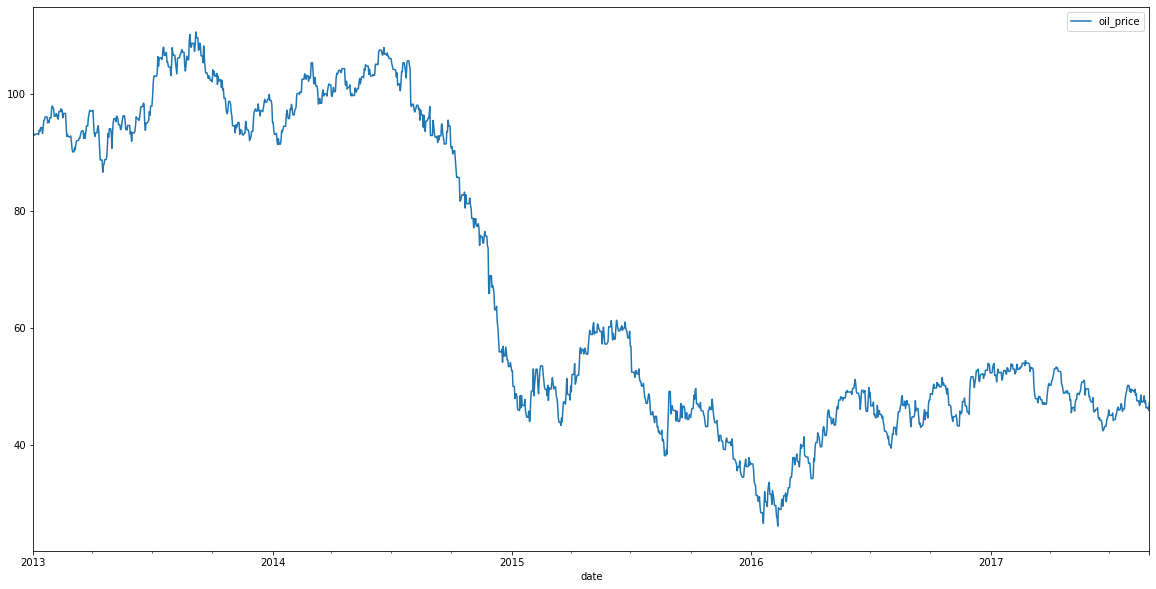

In [16]:
# let's have a look if there is any relation beetween oil prices and sale
df.plot()
oil_prices.plot()

It is difficult to say if there is any relation, based on charts.  
Let's try examine relation between them using correlation function.
We check whether the two variables change in the same direction (positive) or change in different directions (negative), by using covarinace
A covariance value of zero indicates that both variables are completely independent.

In [17]:
pearsonr(df['sales'], oil_prices['oil_price'][:len(df)])

(-0.6209175996570805, 1.5700650185277765e-180)

How we can see between those two variables exist, quite strong negative correlation -0.62, with strong significance (p_value) almost 0.

In [18]:
covariance = np.cov(df['sales'], oil_prices['oil_price'][:len(df)])
covariance

array([[ 5.57793817e+10, -3.77009144e+06],
       [-3.77009144e+06,  6.60940145e+02]])

How we can see covariance rate between those two variables are near to zero, what mean that they completely independent.  
It is what we expected.

So we can assume that oil price can affect our sale and we should take it into consideration.

- transactions

In [19]:
# transactions dataset cointain all transactions by store over time, representing as number of transactions
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [20]:
#let aggregate transactions per day
transactions['date'] = pd.to_datetime(transactions['date'])
transactions_agg = transactions.groupby(['date'])['transactions'].sum().to_frame()
trans_agg = transactions_agg.asfreq('d').fillna(0)

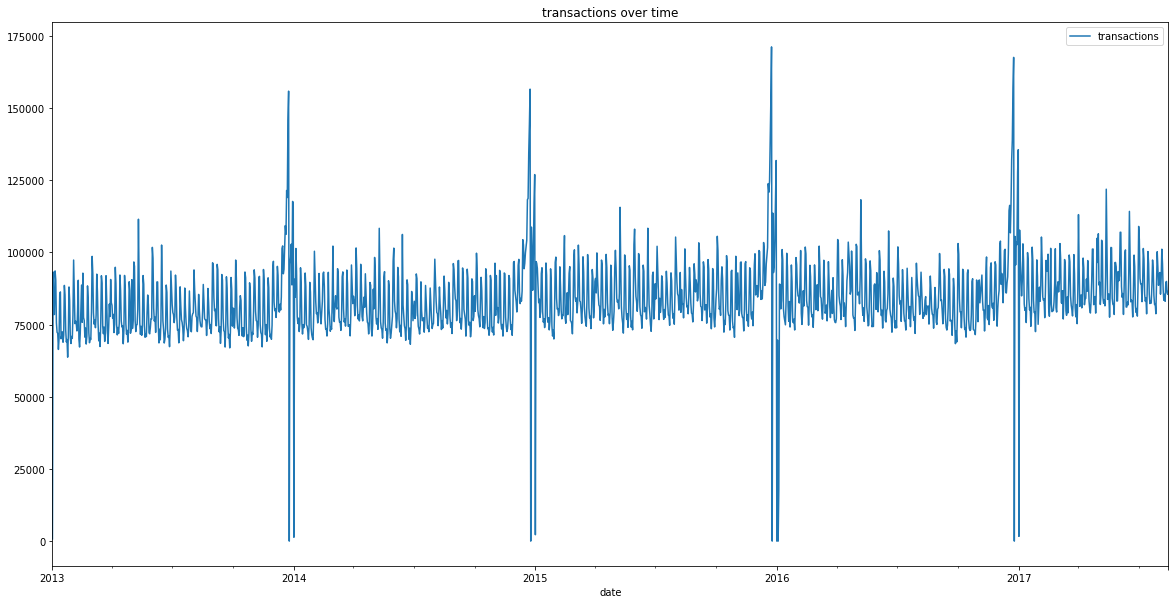

In [21]:
trans_agg.plot()
plt.title('transactions over time')
plt.show()

How we can see number of transactions doesn't have clear trend.  
We can see only seasonal trend at the turn of each year, what is typicall during the Christmas period in retail.

- holidays

In [22]:
# list of local holidays
holidays.sample(10)

,date,type,locale,locale_name,description,transferred
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
128,2014-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False
288,2016-12-08,Holiday,Local,Loja,Fundacion de Loja,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
194,2015-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
311,2017-05-14,Event,National,Ecuador,Dia de la Madre,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
275,2016-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False


In [23]:
#let use only date as an index and add new column [0,1,2,3,4,5] indicate type of holiday, and -1 mean that there wasn't any holidays
holidays['date'] = pd.to_datetime(holidays['date'])
holidays1 = holidays.iloc[:,:2].set_index('date')

le = LabelEncoder()
y = le.fit_transform(holidays1['type'])
holidays1['type'] = y


#delete duplicates, when 
holidays2 = holidays1.groupby(holidays1.index).first()

holidays_list = holidays2.asfreq('d')
holidays_list.fillna(-1, inplace = True)

In [24]:
print("types description", '\n',
      list(le.classes_), '\n',
      list(le.transform(list(le.classes_))))

types description 
 ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'] 
 [0, 1, 2, 3, 4, 5]


In [25]:
# we have 312 days off in range beetwen 2012-03-02 to 2017-12-26
holidays_list['type'].value_counts()

-1.0    1814
 3.0     199
 2.0      49
 0.0      45
 4.0      10
 1.0       5
 5.0       4
Name: type, dtype: int64

We can see that mostly we have holiday type 'Holiday' 199 times, then 49 times 'Event' , 45 times 'Additional' etc

**3. Data concatenate**

In [26]:
# let join all probably usefull data
dataset = pd.concat([holidays_list,df,trans_agg, oil_prices ] , axis =1)
dataset.dropna(inplace = True)

**4. Features engineering**

In [27]:
#Let's add some features to our dateset

#day week (1 - Monday, 7 Sunday)
dataset['wday'] = [datetime.weekday(i)+1 for i in dataset.index]

**5. Train/test split**

In [28]:
# let split data set into test and train
treshold = int(len(dataset)*0.8)

train = dataset.iloc[:treshold,:]
test  = dataset.iloc[treshold:,:]

In [29]:
print('train size lenght is: ', len(train), '\n'
     'test_size lenght is: ', len(test))

train size lenght is:  1350 
test_size lenght is:  338


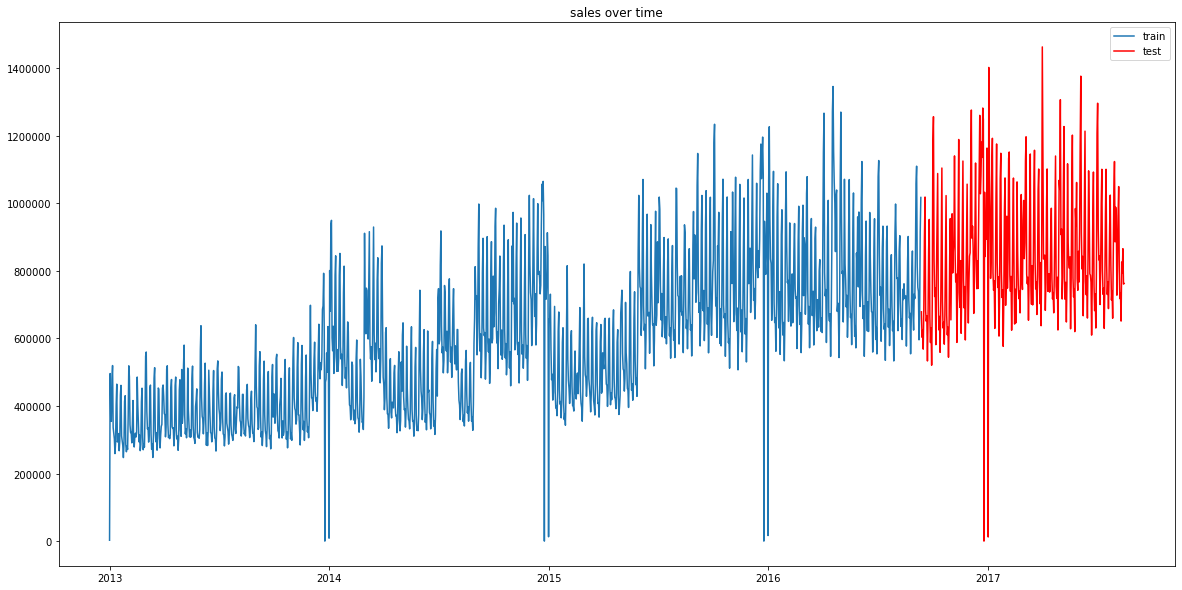

In [30]:
#plot train and test sale 

plt.plot(train.index, train['sales'], label = 'train')
plt.plot(test.index, test['sales'],color = 'red', label = 'test')
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.legend()
plt.show()

In [31]:
#let's determine future holidays in case of forecast need till the end of 2017 year
holidays_future = holidays_list.loc[holidays_list.index > pd.to_datetime('2017-08-15')]
holidays_future[holidays_future.type >= 0]

,type
date,
2017-08-24,3.0
2017-09-28,3.0
2017-09-29,4.0
2017-10-07,3.0
2017-10-09,3.0
2017-11-02,3.0
2017-11-03,3.0
2017-11-06,3.0
2017-11-07,3.0


**6. Stationary test**

In [32]:
# Let check whether our data is stationary or not

# ADF test for 'sale' variable
result_adf = sts.adfuller(train['sales'])
print('p_value = ', result_adf[1])

p_value =  0.1053006430508927


P value > 0.05 mean that our data isn't stationarity.  
In some models we will need to make them stationarity, so let's implement some solutions to gain it

- transforming data to percentage change format, called 'return'

In [33]:
train['sales_ret'] = train['sales'].pct_change(1)*100
train

,type,sales,transactions,oil_price,wday,sales_ret
date,,,,,,
2013-01-01,3.0,2.511619e+03,770.0,93.14,2,NaN
2013-01-02,-1.0,4.960924e+05,93215.0,93.14,3,19651.897805
2013-01-03,-1.0,3.614612e+05,78504.0,92.97,4,-27.138328
2013-01-04,-1.0,3.544597e+05,78494.0,93.12,5,-1.937014
2013-01-05,5.0,4.773501e+05,93573.0,93.20,6,34.669795
...,...,...,...,...,...,...
2016-09-07,-1.0,7.385439e+05,79719.0,45.47,3,-1.734886
2016-09-08,-1.0,5.958493e+05,75262.0,47.63,4,-19.321074
2016-09-09,-1.0,6.589690e+05,79604.0,45.88,5,10.593237


In [34]:
# and let's check again whether data is still stationary or not
# ADF test for 'sales_ret' variable

#first we have to delete or replace inf values
train['sales_ret1'] = [1000 if j == np.inf else train.sales_ret[i] for i,j in enumerate(train.sales_ret)]

result_adf_1 = sts.adfuller(train['sales_ret1'][1:])
print('p_value = ', result_adf_1[1])

p_value =  1.248091531370811e-26


This way let us to gain stationarity in our data, but let try another method too.

- first order differencing

In [35]:
train['sales_diff'] = train['sales'].diff(1)

In [36]:
# ADF test for 'sales_diff' variable

result_adf_2 = sts.adfuller(train['sales_diff'][1:])
print('p_value = ', result_adf_2[1])

p_value =  4.072269153211531e-14


Thanks to the first order differencing our data is totally stationary

In [82]:
#let create return and 1st order differencing data also for our test dataset
test1 = pd.concat([train.iloc[-1:,:5],test])
test1['sales_ret1'] =  test1['sales'].pct_change(1)*100
test1['sales_diff'] =   test1['sales'].diff(1)
test = test1.iloc[1:]

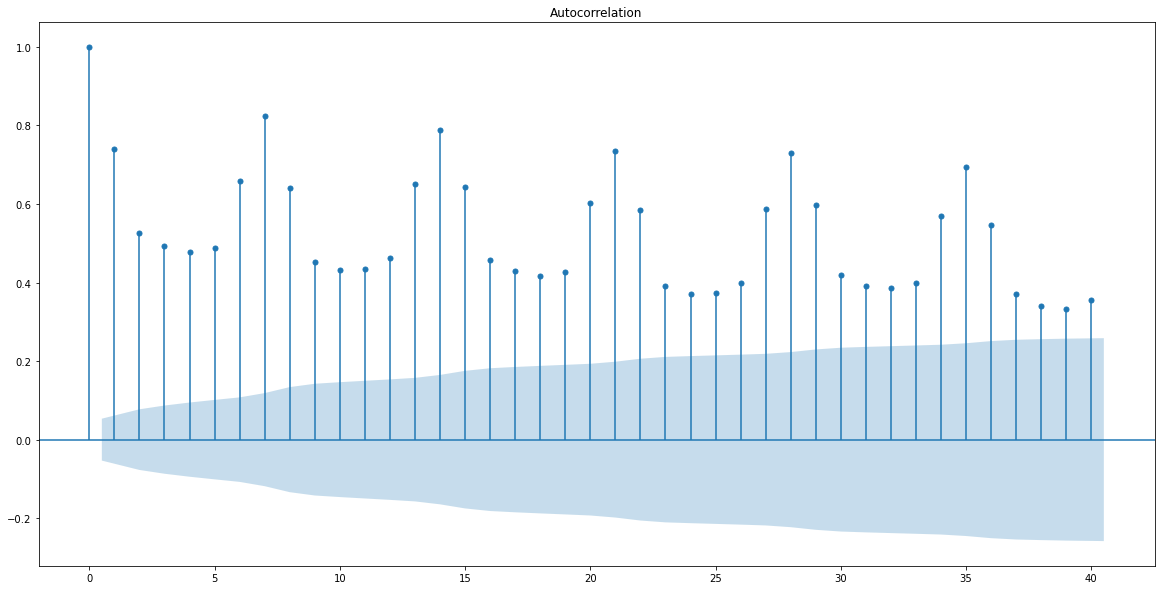

In [38]:
# Let check if our data isn't white noise or random walk 
sgt.plot_acf(train['sales'], lags = 40)
plt.show()

As we can see all data (till 40 lag) is significant, so we can't consider this data set as a white noise.

*Random walk testing*  
As we knwo, our data isn't stationary so it can be consider as a random walk,  
so we need to see how look autocorrelation for first-order diffence data

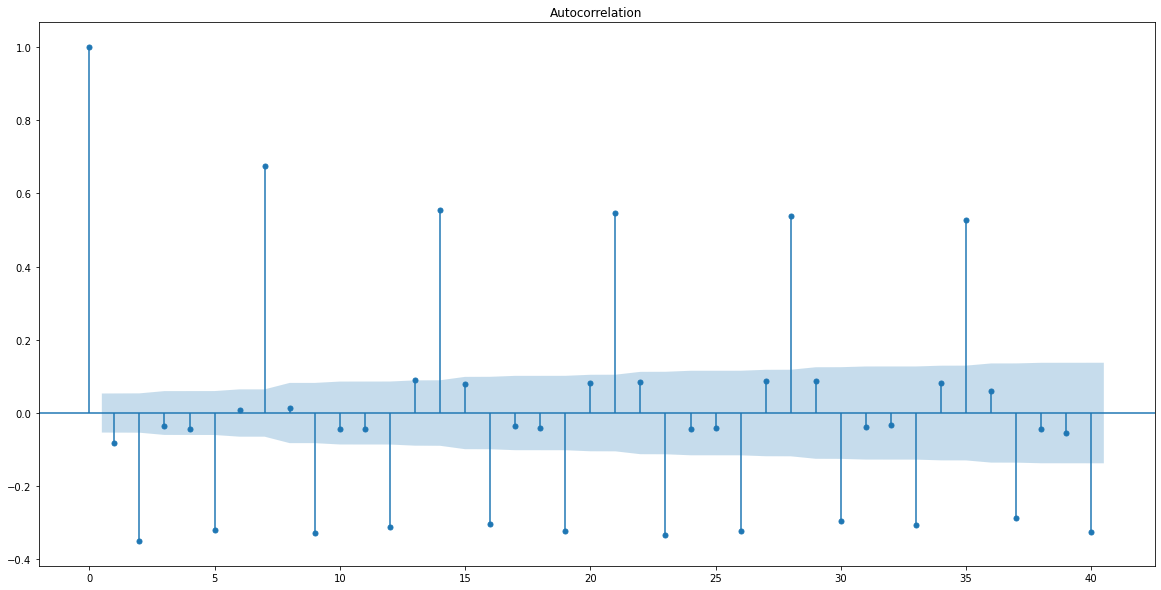

In [39]:
sgt.plot_acf(train['sales_diff'][1:],lags =40)
plt.show()

Even first-order differenced data isn't random noise, so we can't talk about random walk in our data.  
It is good information, because we can expect that are data are able to be predict.

To have full view on our data let's check also partial autocorrelation function

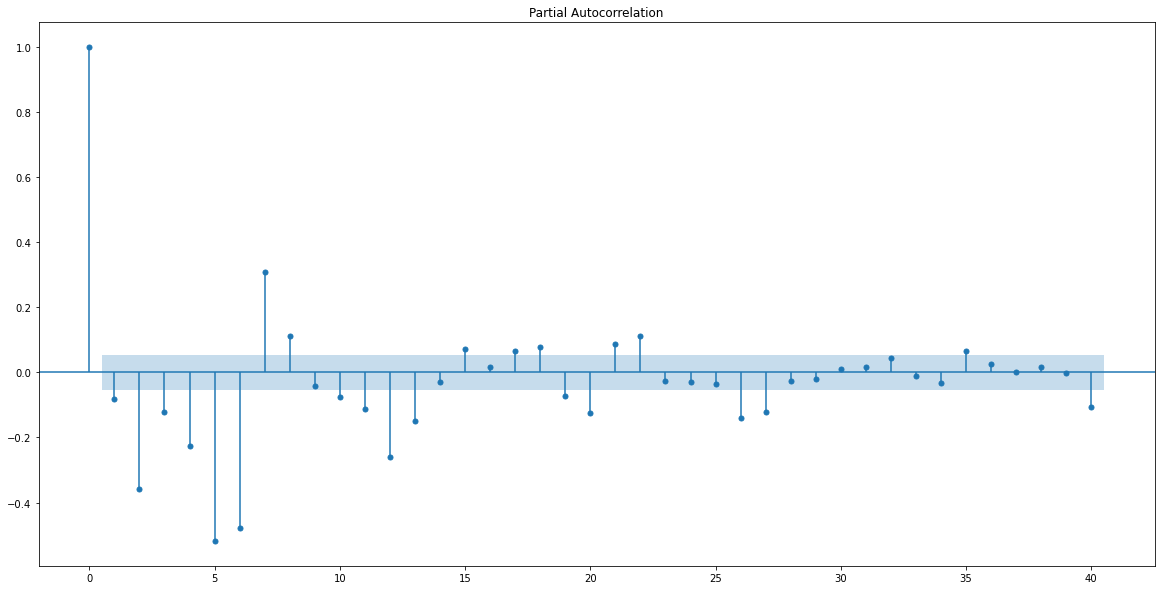

In [40]:
sgt.plot_pacf(train['sales_diff'][1:], lags = 40, method = 'ols')
plt.show()

According to the results from previous pacf_plot it seems than at least 8 periods before, but also 13 or even 22lags can be use to predict future sale.
We also check 7 periods, because it is common trend in retail.

**7. Trend decomposition**

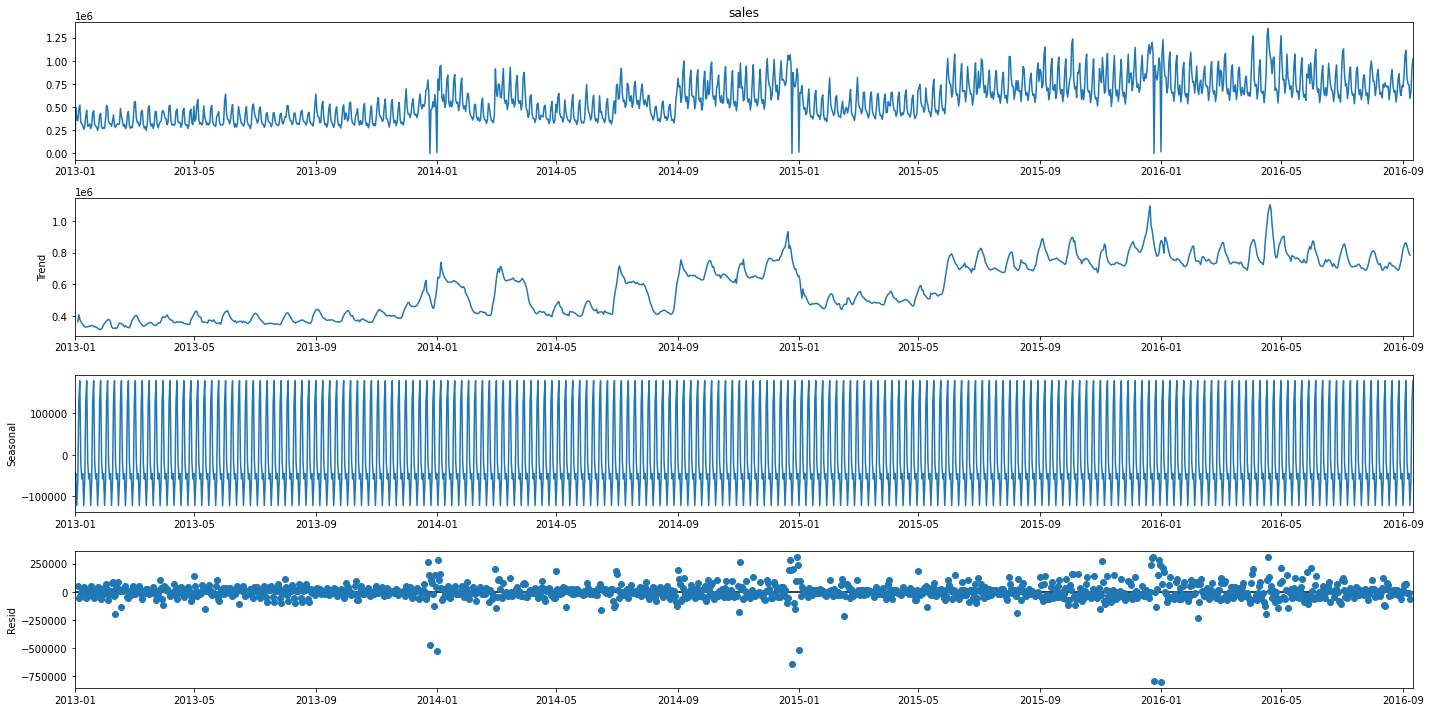

In [41]:
#Let furthermore check trend composition to know what cycles we can noticed

decomp = seasonal_decompose(train['sales'])
decomp.plot()
plt.show()

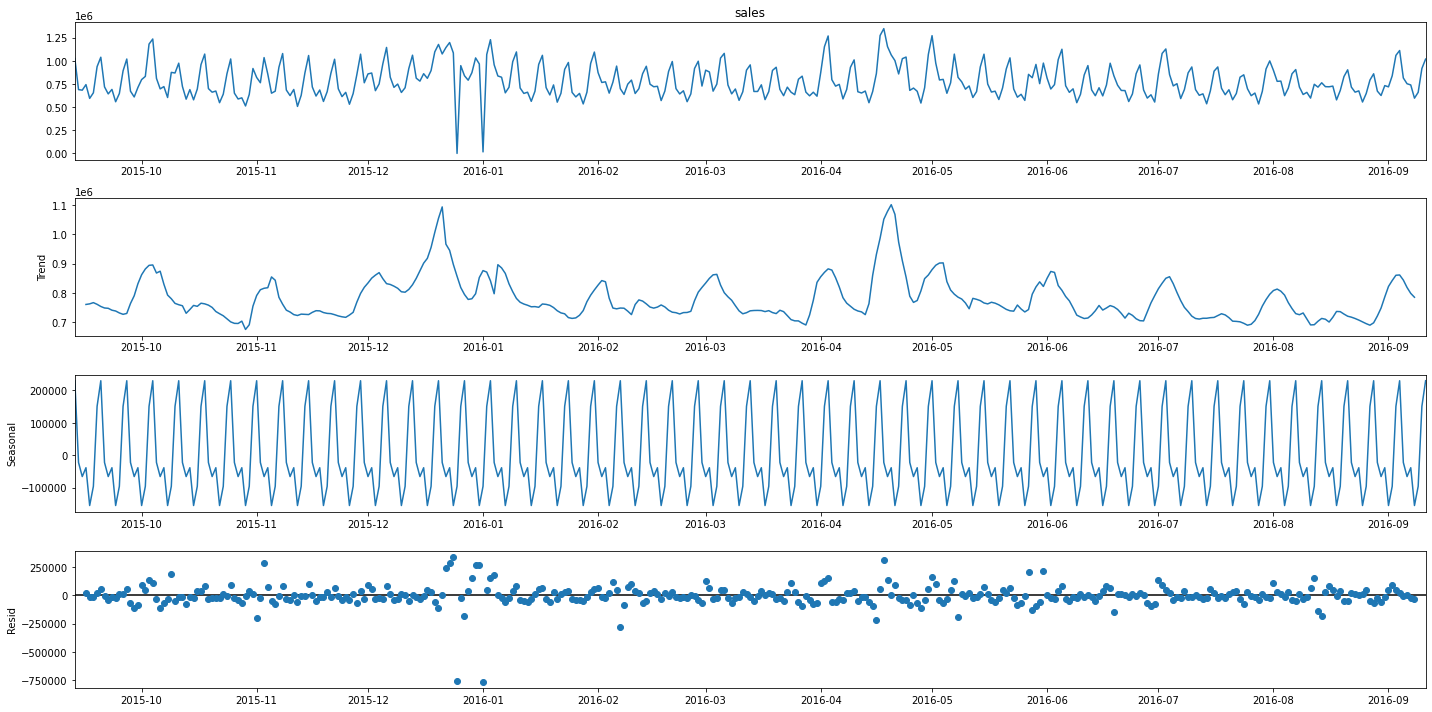

In [42]:
#only last 12 months
decomp_year = seasonal_decompose(train['sales'][-365:])
decomp_year.plot()
plt.show()

How we can see there is a significant seasonal component in our data, and seasonality pick is four times per month.
Our residuals errors are close to zero, but at the year turn appear to be bigger than usually.

**8. First simple models**

- ARMA

Let's create some simple models to get a banchmark for future improvments.  
First we will rank models by their Log Likelihood ratio.

In [70]:
#let's create a test to compare simple models
def LLR_test(model1, model2, DF = 1):
    L1 = model1.llf
    L2 = model2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [44]:
# simple ARMA models
model_arma_7_0 = ARMA(train['sales_diff'][1:], order = (7,0)).fit()
model_arma_7_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 0)   Log Likelihood              -17436.943
Method:                       css-mle   S.D. of innovations          99235.384
Date:                Sun, 10 Apr 2022   AIC                          34891.886
Time:                        14:17:25   BIC                          34938.750
Sample:                    01-02-2013   HQIC                         34909.437
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3036    859.023      0.876      0.381    -931.350    2435.957
ar.L1.sales_diff    -0.4040      0.026    -15.522      0.000      -0.455      -0.353
ar.L2.sales_diff    -0.4926      0.027    -18.266      0.000      -0.545      -0.440
ar.L3.sales_diff    -0.4088      0.028    -14.833      0.000      -0.463      -0.355
ar.L4.sales_diff    -0.4000      0.028    -14.480      0.000      -0.454      -0.346
ar.L5.sales_diff    -0.4502      0.028    -16.360      0.000      -0.504      -0.396
ar.L6.sales_diff    -0.3091      0.027    -11.457      0.000      -0.362      -0.256
ar.L7.sales_diff     0.3107      0.026     11.929      0.000       0.260       0.362
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0051           -0.4809j            1.1142           -0.4290
AR.2           -1.0051           +0.4809j            1.1142            0.4290
AR.3           -0.2401           -1.0168j            1.0447           -0.2869
AR.4           -0.2401           +1.0168j            1.0447            0.2869
AR.5            0.6516           -0.8149j            1.0434           -0.1427
AR.6            0.6516           +0.8149j            1.0434            0.1427
AR.7            2.1820           -0.0000j            2.1820           -0.0000
-----------------------------------------------------------------------------
"""

In [46]:
model_arma_7_1 = ARMA(train['sales_diff'][1:], order = (7,1)).fit()
model_arma_7_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 1)   Log Likelihood              -17431.254
Method:                       css-mle   S.D. of innovations          98815.340
Date:                Sun, 10 Apr 2022   AIC                          34882.507
Time:                        14:17:57   BIC                          34934.578
Sample:                    01-02-2013   HQIC                         34902.008
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3035    943.304      0.798      0.425   -1096.537    2601.145
ar.L1.sales_diff    -0.2054      0.056     -3.658      0.000      -0.315      -0.095
ar.L2.sales_diff    -0.3806      0.036    -10.455      0.000      -0.452      -0.309
ar.L3.sales_diff    -0.2686      0.043     -6.278      0.000      -0.352      -0.185
ar.L4.sales_diff    -0.2811      0.038     -7.338      0.000      -0.356      -0.206
ar.L5.sales_diff    -0.3320      0.038     -8.780      0.000      -0.406      -0.258
ar.L6.sales_diff    -0.1752      0.041     -4.247      0.000      -0.256      -0.094
ar.L7.sales_diff     0.4102      0.033     12.490      0.000       0.346       0.475
ma.L1.sales_diff    -0.2193      0.058     -3.767      0.000      -0.333      -0.105
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0153           -0.4940j            1.1291           -0.4279
AR.2           -1.0153           +0.4940j            1.1291            0.4279
AR.3           -0.2340           -1.0178j            1.0443           -0.2860
AR.4           -0.2340           +1.0178j            1.0443            0.2860
AR.5            0.6465           -0.8099j            1.0362           -0.1428
AR.6            0.6465           +0.8099j            1.0362            0.1428
AR.7            1.6328           -0.0000j            1.6328           -0.0000
MA.1            4.5593           +0.0000j            4.5593            0.0000
-----------------------------------------------------------------------------
"""

In [48]:
#let create a function that provide us model name and his results, we will use it then in the loop
AR_comp = [7,8,12,15,22]
MA_comp = [1,2,3,5,7]

def model_arma(x,AR_comp, MA_comp,name = 'name'):
    model = ARMA(x, order =(AR_comp, MA_comp))
    result = model.fit()
    return {name: round(result.llf,3)}

In [49]:
#let check a few diffent model, which gain the best results, according to the Log Likelihood
loop_results = dict()

for ar in AR_comp:
    for ma in MA_comp:
        try:
            x = model_arma(train['sales_diff'][1:], ar, ma, name = 'model_arma_' + str(ar) + '_' + str(ma))
            loop_results.update(x)
            print('model_arma_' + str(ar) +"_" + str(ma))
        except:
            continue

model_arma_7_1
model_arma_7_2
model_arma_7_3
model_arma_7_5
model_arma_7_7
model_arma_8_1
model_arma_8_2
model_arma_8_3
model_arma_8_5
model_arma_8_7
model_arma_12_1
model_arma_12_2
model_arma_12_7
model_arma_15_1
model_arma_15_3
model_arma_15_5
model_arma_22_1
model_arma_22_2


{'model_arma_7_1': -17431.254,
 'model_arma_7_2': -17426.675,
 'model_arma_7_3': -17425.074,
 'model_arma_7_5': -17364.03,
 'model_arma_7_7': -17302.503,
 'model_arma_8_1': -17427.929,
 'model_arma_8_2': -17365.794,
 'model_arma_8_3': -17360.303,
 'model_arma_8_5': -17339.854,
 'model_arma_8_7': -17301.937,
 'model_arma_12_1': -17354.974,
 'model_arma_12_2': -17331.438,
 'model_arma_12_7': -17288.971,
 'model_arma_15_1': -17346.41,
 'model_arma_15_3': -17342.224,
 'model_arma_15_5': -17313.742,
 'model_arma_22_1': -17313.038,
 'model_arma_22_2': -17312.784}

In [54]:
#Let check 5 best models
best_arma = pd.DataFrame([loop_results]).T.rename(columns = {0: 'result'})
best_arma.sort_values(by = 'result', ascending = False).head(5)

,result
model_arma_12_7,-17288.971
model_arma_8_7,-17301.937
model_arma_7_7,-17302.503
model_arma_22_2,-17312.784
model_arma_22_1,-17313.038


How we can see best models has mostly 7 MA lags, and the more AR lags the better, but not too many, because models don't perform much better and their computation last very long.  
But let's check if all coefitents are significant

In [64]:
model_arma_12_7 = ARMA(train['sales_diff'][1:], order = (12,7))
results_arma_12_7 = model_arma_12_7.fit()
results_arma_12_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                    ARMA(12, 7)   Log Likelihood              -17288.971
Method:                       css-mle   S.D. of innovations          88126.409
Date:                Sun, 10 Apr 2022   AIC                          34619.941
Time:                        19:37:15   BIC                          34729.291
Sample:                    01-02-2013   HQIC                         34660.894
                         - 09-11-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               752.2965      0.135   5566.468      0.000     752.032     752.561
ar.L1.sales_diff     -0.3440        nan        nan        nan         nan         nan
ar.L2.sales_diff     -0.3651   1.82e-05  -2.01e+04      0.000      -0.365      -0.365
ar.L3.sales_diff     -0.5155   2.87e-05  -1.79e+04      0.000      -0.516      -0.515
ar.L4.sales_diff     -0.0022   2.53e-05    -86.345      0.000      -0.002      -0.002
ar.L5.sales_diff     -0.6492        nan        nan        nan         nan         nan
ar.L6.sales_diff     -0.0427   1.31e-06  -3.27e+04      0.000      -0.043      -0.043
ar.L7.sales_diff      0.5653        nan        nan        nan         nan         nan
ar.L8.sales_diff      0.1495   7.33e-05   2040.267      0.000       0.149       0.150
ar.L9.sales_diff      0.1303   6.11e-06   2.13e+04      0.000       0.130       0.130
ar.L10.sales_diff     0.1137   5.72e-05   1987.744      0.000       0.114       0.114
ar.L11.sales_diff    -0.0583   5.15e-05  -1133.929      0.000      -0.058      -0.058
ar.L12.sales_diff     0.1400        nan        nan        nan         nan         nan
ma.L1.sales_diff     -0.1940      0.023     -8.258      0.000      -0.240      -0.148
ma.L2.sales_diff      0.0149      0.021      0.720      0.472      -0.026       0.055
ma.L3.sales_diff      0.2598      0.019     13.618      0.000       0.222       0.297
ma.L4.sales_diff     -0.3894      0.014    -28.733      0.000      -0.416      -0.363
ma.L5.sales_diff      0.5227      0.016     32.572      0.000       0.491       0.554
ma.L6.sales_diff     -0.4565      0.022    -20.686      0.000      -0.500      -0.413
ma.L7.sales_diff     -0.5260      0.026    -20.520      0.000      -0.576      -0.476
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0329           -0.0000j            1.0329           -0.5000
AR.2            -1.0580           -0.4585j            1.1531           -0.4349
AR.3            -1.0580           +0.4585j            1.1531            0.4349
AR.4            -0.2226           -0.9749j            1.0000           -0.2857
AR.5            -0.2226           +0.9749j            1.0000            0.2857
AR.6            -0.2876           -1.3143j            1.3454           -0.2843
AR.7            -0.2876           +1.3143j            1.3454            0.2843
AR.8             0.6236           -0.7818j            1.0000           -0.1428
AR.9             0.6236           +0.7818j            1.0000            0.1428
AR.10            1.1879           -0.0000j            1.1879           -0.0000
AR.11            1.0753           -1.1232j            1.5550           -0.1285
AR.12            1.0753           +1.1232j            1.5550            0.1285

In this model we got some Nan's in summary, it can mean that our model isn't right for our predictions, and there is a problem with model converge

In [65]:
model_arma_8_7 = ARMA(train['sales_diff'][1:], order = (8,7))
results_arma_8_7 = model_arma_8_7.fit()
results_arma_8_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(8, 7)   Log Likelihood              -17301.937
Method:                       css-mle   S.D. of innovations          89542.571
Date:                Sun, 10 Apr 2022   AIC                          34637.874
Time:                        19:41:44   BIC                          34726.395
Sample:                    01-02-2013   HQIC                         34671.026
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2935    457.938      1.643      0.100    -145.248    1649.835
ar.L1.sales_diff    -0.4060      0.071     -5.713      0.000      -0.545      -0.267
ar.L2.sales_diff    -0.4807      0.044    -10.834      0.000      -0.568      -0.394
ar.L3.sales_diff    -0.5593      0.055    -10.239      0.000      -0.666      -0.452
ar.L4.sales_diff    -0.3264      0.055     -5.881      0.000      -0.435      -0.218
ar.L5.sales_diff    -0.6689      0.043    -15.572      0.000      -0.753      -0.585
ar.L6.sales_diff    -0.2826      0.062     -4.544      0.000      -0.404      -0.161
ar.L7.sales_diff     0.3630      0.036     10.028      0.000       0.292       0.434
ar.L8.sales_diff     0.0187      0.032      0.592      0.554      -0.043       0.080
ma.L1.sales_diff    -0.1360      0.070     -1.934      0.053      -0.274       0.002
ma.L2.sales_diff     0.1075      0.064      1.679      0.093      -0.018       0.233
ma.L3.sales_diff     0.2187      0.058      3.771      0.000       0.105       0.332
ma.L4.sales_diff    -0.1689      0.059     -2.849      0.004      -0.285      -0.053
ma.L5.sales_diff     0.3978      0.052      7.611      0.000       0.295       0.500
ma.L6.sales_diff    -0.2800      0.056     -5.010      0.000      -0.389      -0.170
ma.L7.sales_diff    -0.5392      0.057     -9.516      0.000      -0.650      -0.428
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7818j            1.0001           -0.1428
AR.2            0.6237           +0.7818j            1.0001            0.1428
AR.3           -0.2229           -0.9758j            1.0009           -0.2857
AR.4           -0.2229           +0.9758j            1.0009            0.2857
AR.5           -1.0820           -0.3738j            1.1447           -0.4471
AR.6           -1.0820           +0.3738j            1.1447            0.4471
AR.7            2.0285           -0.0000j            2.0285           -0.0000
AR.8          -20.1088           -0.0000j           20.1088           -0.5000
MA.1            1.1173           -0.0000j            1.1173           -0.0000
MA.2            0.6287           -0.7879j            1.0080           -0.1428
MA.3            0.6287           +0.7879j            1.0080            0.1428
MA.4           -0.2266           -0.9975j            1.0229           -0.2856
MA.5           -0.2266           +0.9975j            1.0229            0.2856
MA.6           -1.2204           -0.2682j            1.2495           -0.4656
MA.7           -1.2204           +0.2682j            1.2495            0.4656
-----------------------------------------------------------------------------
"""

In this model last AR coeficient isn't significant, so let try model ARMA(7,7)

In [106]:
model_arma_7_7 = ARMA(train['sales_diff'][1:], order = (7,7))
results_arma_7_7 = model_arma_7_7.fit()
results_arma_7_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 7)   Log Likelihood              -17302.503
Method:                       css-mle   S.D. of innovations          89587.050
Date:                Sun, 10 Apr 2022   AIC                          34637.005
Time:                        20:40:05   BIC                          34720.319
Sample:                    01-02-2013   HQIC                         34668.208
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2441    448.973      1.675      0.094    -127.727    1632.216
ar.L1.sales_diff    -0.3246      0.088     -3.669      0.000      -0.498      -0.151
ar.L2.sales_diff    -0.4834      0.051     -9.483      0.000      -0.583      -0.384
ar.L3.sales_diff    -0.5063      0.058     -8.660      0.000      -0.621      -0.392
ar.L4.sales_diff    -0.3105      0.089     -3.486      0.000      -0.485      -0.136
ar.L5.sales_diff    -0.6423      0.044    -14.603      0.000      -0.728      -0.556
ar.L6.sales_diff    -0.2361      0.106     -2.237      0.025      -0.443      -0.029
ar.L7.sales_diff     0.3624      0.030     12.026      0.000       0.303       0.421
ma.L1.sales_diff    -0.2137      0.088     -2.417      0.016      -0.387      -0.040
ma.L2.sales_diff     0.1549      0.057      2.738      0.006       0.044       0.266
ma.L3.sales_diff     0.1755      0.057      3.091      0.002       0.064       0.287
ma.L4.sales_diff    -0.1495      0.081     -1.841      0.066      -0.309       0.010
ma.L5.sales_diff     0.3880      0.080      4.862      0.000       0.232       0.544
ma.L6.sales_diff    -0.3179      0.095     -3.361      0.001      -0.503      -0.133
ma.L7.sales_diff    -0.4867      0.081     -5.980      0.000      -0.646      -0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0928           -0.3958j            1.1622           -0.4447
AR.2           -1.0928           +0.3958j            1.1622            0.4447
AR.3           -0.2232           -0.9764j            1.0016           -0.2858
AR.4           -0.2232           +0.9764j            1.0016            0.2858
AR.5            0.6237           -0.7818j            1.0001           -0.1428
AR.6            0.6237           +0.7818j            1.0001            0.1428
AR.7            2.0360           -0.0000j            2.0360           -0.0000
MA.1            1.1123           -0.0000j            1.1123           -0.0000
MA.2            0.6284           -0.7871j            1.0072           -0.1428
MA.3            0.6284           +0.7871j            1.0072            0.1428
MA.4           -0.2286           -1.0038j            1.0295           -0.2856
MA.5           -0.2286           +1.0038j            1.0295            0.2856
MA.6           -1.2826           -0.2704j            1.3108           -0.4669
MA.7           -1.2826           +0.2704j            1.3108            0.4669
-----------------------------------------------------------------------------
"""

In [108]:
LLR_test(results_arma_7_7, results_arma_8_7, DF = 1)

0.287

Neverthless we will call our model ARMA(8,7) as our current benchmark with following results

In [88]:
arma_pred = results_arma_8_7.predict(test.index[0],test.index[-1])
arma_train_pred = results_arma_8_7.predict(train.index[1],train.index[-1])

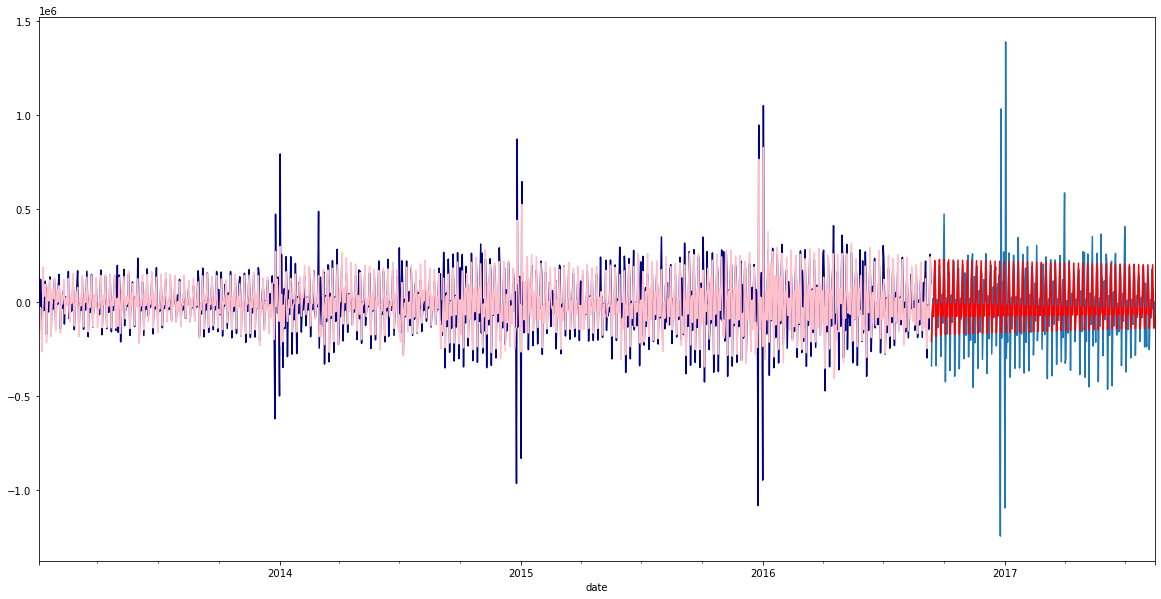

In [94]:
test['sales_diff'].plot()
train['sales_diff'][1:].plot(color= 'navy')
arma_pred.plot(color = 'red')
arma_train_pred.plot(color = 'pink')

plt.show()

In [92]:
print('R2 score train is: ', round(r2_score(train['sales_diff'][1:], arma_train_pred),3))
print('R2 score test is: ', round(r2_score(test['sales_diff'], arma_pred),3))

R2 score train is:  0.659
R2 score test is:  0.344


So our first simple model has 0.659 on train set and 0.344 R2 score on test set.  
Let's improve it!

In [ ]:
#spojrz na wykres wynikow jakie modele lepiej dzialaja a jakie sobie odpusic dalej

In [ ]:
# AR_comp = range(1, 3)
# MA_comp = range(1,3)
# loop_results

czy najlepsze piec modeli ma parametry dobre, i czy na wszystkie lagi puszczac model

# sprawdz kilka modeli z I = 1
## odpowiedz sobie na pytanie czy dodajac po prostu i = 1 i zmieniajac dane z diff na normalne 
# poprawiamy wyniki, czy inne modele sa lepsze w takim wydaniu

In [ ]:
loop_results

- ARIMA

In [102]:
AR_comp1 = [7,8]
MA_comp1 = [1,2,3,5,7]

In [100]:
#let check if several models with integrated parameter can achive better result on non-stationarity data
#We need integration on level 1 to make our data stationary

#let create a function that provide us model name and his results, we will use it then in the loop
#AR_comp1 = [7,8,12,15,22]
#MA_comp1 = [1,2,3,5,7]

def model_arima(x,AR_comp1, MA_comp1,name = 'name'):
    model = ARIMA(x, order =(AR_comp1, 1, MA_comp1))
    result = model.fit()
    return {name: round(result.llf,3)}

In [105]:
loop_results_integrated = dict()

for ar in AR_comp1:
    for ma in MA_comp1:
        try:
            x = model_arima(train['sales'], ar, ma, name = 'model_arima_integ' + str(ar) + '_' + str(ma))
            loop_results_integrated.update(x)
            print('model_arima_' + str(ar) +"_" + str(ma))
        except:
            continue    

model_arima_7_1
model_arima_7_2
model_arima_7_3
model_arima_7_5
model_arima_7_7
model_arima_8_1
model_arima_8_2
model_arima_8_3
model_arima_8_5
model_arima_8_7


{}

In [107]:
loop_results

{'model_arma_7_1': -17431.254,
 'model_arma_7_2': -17426.675,
 'model_arma_7_3': -17425.074,
 'model_arma_7_5': -17364.03,
 'model_arma_7_7': -17302.503,
 'model_arma_8_1': -17427.929,
 'model_arma_8_2': -17365.794,
 'model_arma_8_3': -17360.303,
 'model_arma_8_5': -17339.854,
 'model_arma_8_7': -17301.937,
 'model_arma_12_1': -17354.974,
 'model_arma_12_2': -17331.438,
 'model_arma_12_7': -17288.971,
 'model_arma_15_1': -17346.41,
 'model_arma_15_3': -17342.224,
 'model_arma_15_5': -17313.742,
 'model_arma_22_1': -17313.038,
 'model_arma_22_2': -17312.784,
 'model_arima_integ7_1': -17431.254,
 'model_arima_integ7_2': -17426.675,
 'model_arima_integ7_3': -17425.074,
 'model_arima_integ7_5': -17364.03,
 'model_arima_integ7_7': -17302.503,
 'model_arima_integ8_1': -17427.929,
 'model_arima_integ8_2': -17365.794,
 'model_arima_integ8_3': -17360.303,
 'model_arima_integ8_5': -17339.854,
 'model_arima_integ8_7': -17301.937}

In [ ]:
#Let check 5 best models
best_arma = pd.DataFrame([loop_results]).T.rename(columns = {0: 'result'})
best_arma.sort_values(by = 'result', ascending = False).head(5)

In [ ]:
#porob lagi do danych pozniej do proby innego modelu,
# mozna sprobowac osobno zaprognozowac oil prices by moc na tym oprzec prognoze 



Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.